In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

In [0]:
!pip install pyarrow

## Read in
Start working from the aggregated dataframe `agg_df`.

In [0]:
train_df = pd.read_feather(f'{PATH_FEATURES}/sample_new_151')

train_df.head()

,bookingID,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_mean,gyro_z_std,second_max,second_mean,second_std,Speed_max,Speed_mean,Speed_std,total_a_max,total_a_mean,total_a_std,total_gyro_max,total_gyro_mean,total_gyro_std,roll_max,roll_mean,roll_std,...,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_mean,roll_fo_min,roll_fo_max,roll_so_mean,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_mean,pitch_fo_min,pitch_fo_max,pitch_so_mean,pitch_so_min,pitch_so_max,pitch_sign_change,label
0,0,48.000,10.165339,3.855898,359.979767,176.526099,129.231351,4.782614,-0.711264,0.928022,-6.119916,-9.613822,0.639934,2.318857,-1.619658,1.141266,0.438371,0.003328,0.065954,0.469724,-0.006118,0.100225,0.372807,-0.004188,0.063685,1589.0,903.526892,533.745097,22.946083,8.994822,7.199919,12.988328,9.886164,0.624159,0.749086,0.100772,0.091389,-1.347602,-1.737242,0.116742,...,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,0.000171,-0.470042,0.615583,0.000202,-0.940743,1.047816,0.0,0.000157,-0.441226,0.505558,0.000210,-0.853901,0.918500,278.0,0
1,1,7.709,3.718763,0.597933,337.000000,124.198590,89.861236,3.813341,-0.525406,0.744157,12.536156,9.532086,0.533915,1.481293,-2.198999,0.854271,0.126536,-0.002467,0.027740,0.470837,-0.007540,0.091699,0.235131,0.000405,0.033838,1034.0,581.175088,289.339367,21.882141,7.881588,7.059362,12.790147,9.862507,0.519956,0.717864,0.066187,0.077463,2.137340,1.797626,0.088049,...,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,-0.000096,-0.537245,0.523479,-0.000285,-0.783427,0.965273,0.0,0.000099,-0.488136,0.452367,-0.000123,-0.832619,0.931832,180.0,1
2,2,8.000,3.930626,1.117354,354.000000,173.794872,119.316520,1.956122,0.306786,0.756589,13.333716,9.843183,0.505693,2.312870,0.139347,1.020021,0.282162,0.006458,0.053903,0.431695,-0.012861,0.117321,0.255884,0.002597,0.036215,825.0,339.441026,356.319445,9.360483,3.157213,2.897762,13.403410,9.929590,0.515173,0.463685,0.097433,0.093028,1.891112,1.556422,0.102860,...,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,-0.000391,-0.436176,0.478420,-0.000621,-0.777169,0.635099,0.0,-0.000304,-0.310418,0.329223,-0.001784,-0.639641,0.490599,80.0,1
3,4,10.000,10.000000,0.000000,353.855377,151.807013,71.273774,2.019635,-0.365117,0.527220,-7.064984,-9.406439,0.598023,0.296381,-2.613639,0.779529,0.438732,-0.022884,0.042342,0.652628,0.023232,0.112567,0.505220,-0.000376,0.065927,1094.0,547.495430,315.962793,19.780001,6.150996,5.595901,21.053265,9.813434,0.620066,0.661675,0.108875,0.089501,-1.537207,-1.841256,0.077592,...,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.000110,-1.186005,1.002399,519.0,-0.000012,-0.481751,0.561944,0.000108,-1.043695,0.714401,536.0,-0.000184,-0.366293,0.371167,0.000134,-0.728194,0.595339,0.0,0.000184,-0.325465,0.368603,-0.

In [0]:
# def encode_FE(df, col):
#     cv = df[col].value_counts()
#     nm = col+'_FE'
#     df[nm] = df[col].map(cv)
    
# freq_features = ['gyro_x_mean', 'gyro_z_so_mean', 'total_gyro_mean',
#                  'roll_max', 'Speed_min', 'total_gyro_min', 
#                  'horsepower_min', 'Bearing_min']    
    
# for c in freq_features:     
#   encode_FE(train_df, c)

In [65]:
select_f = features_df['features'].tolist()

len(select_f)

37

In [66]:
exclude = ['label', 'bookingID']

# features = [c for c in train_df.columns if c not in exclude]

features = select_f

len(features)

37

## Baseline
1. `lightgbm`

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

In [0]:
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'lambda_l1': 5,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

In [70]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.829444	valid_1's auc: 0.730822
[200]	training's auc: 0.881086	valid_1's auc: 0.730693
[300]	training's auc: 0.918177	valid_1's auc: 0.729874
Early stopping, best iteration is:
[215]	training's auc: 0.887499	valid_1's auc: 0.73129
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.826645	valid_1's auc: 0.73577
[200]	training's auc: 0.881917	valid_1's auc: 0.736116
Early stopping, best iteration is:
[144]	training's auc: 0.853808	valid_1's auc: 0.738501
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.827051	valid_1's auc: 0.754879
Early stopping, best iteration is:
[73]	training's auc: 0.807774	valid_1's auc: 0.756242
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.830551	valid_1's auc: 0.722567
[200]	training's auc: 0.883429	valid_1's auc: 0.720287
Early stopping, best iteration is:
[104]	

In [71]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.735518388, std: 0.011514486. All auc: 0.734977879.


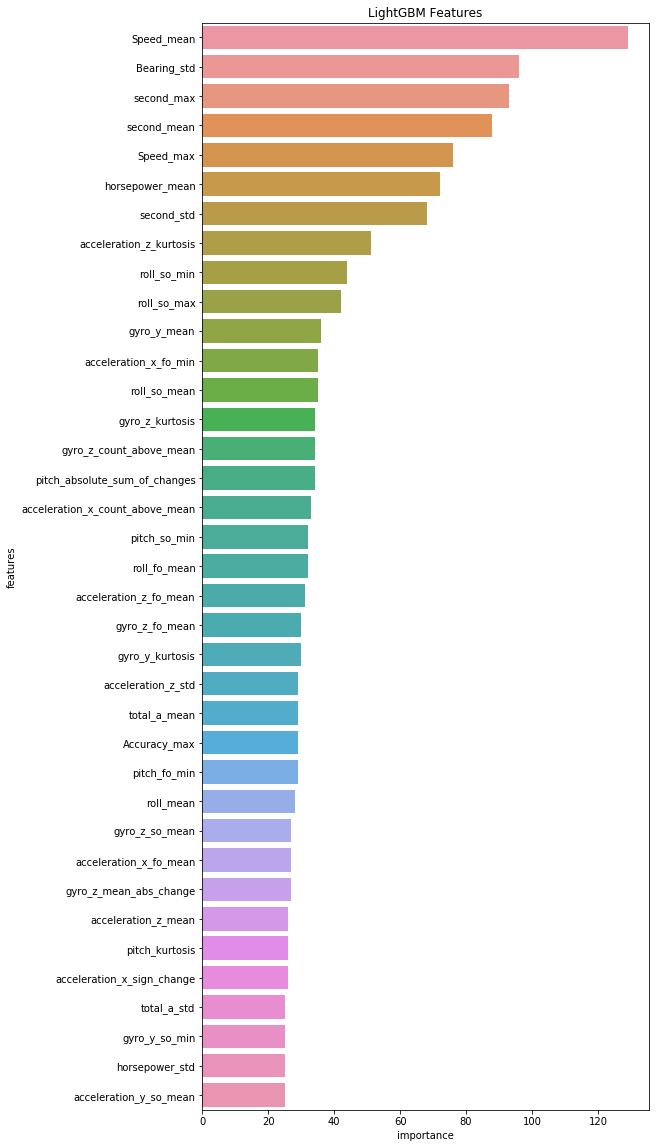

In [64]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

features_df = features_df[:int(len(features)/2)]

plt.figure(figsize=(8,20))
sns.barplot(x="importance", y="features", 
            data=features_df)
plt.title('LightGBM Features')
plt.show()

In [74]:
!pip install pygam

     |████████████████████████████████| 1.8MB 3.4MB/s 


In [0]:
from pygam import LogisticGAM
from pygam import PoissonGAM, s, te, f

In [0]:
features_sub = features[:9]

In [0]:
X = train_df[features].values
y = train_df['label'].values

ValueError: ignored

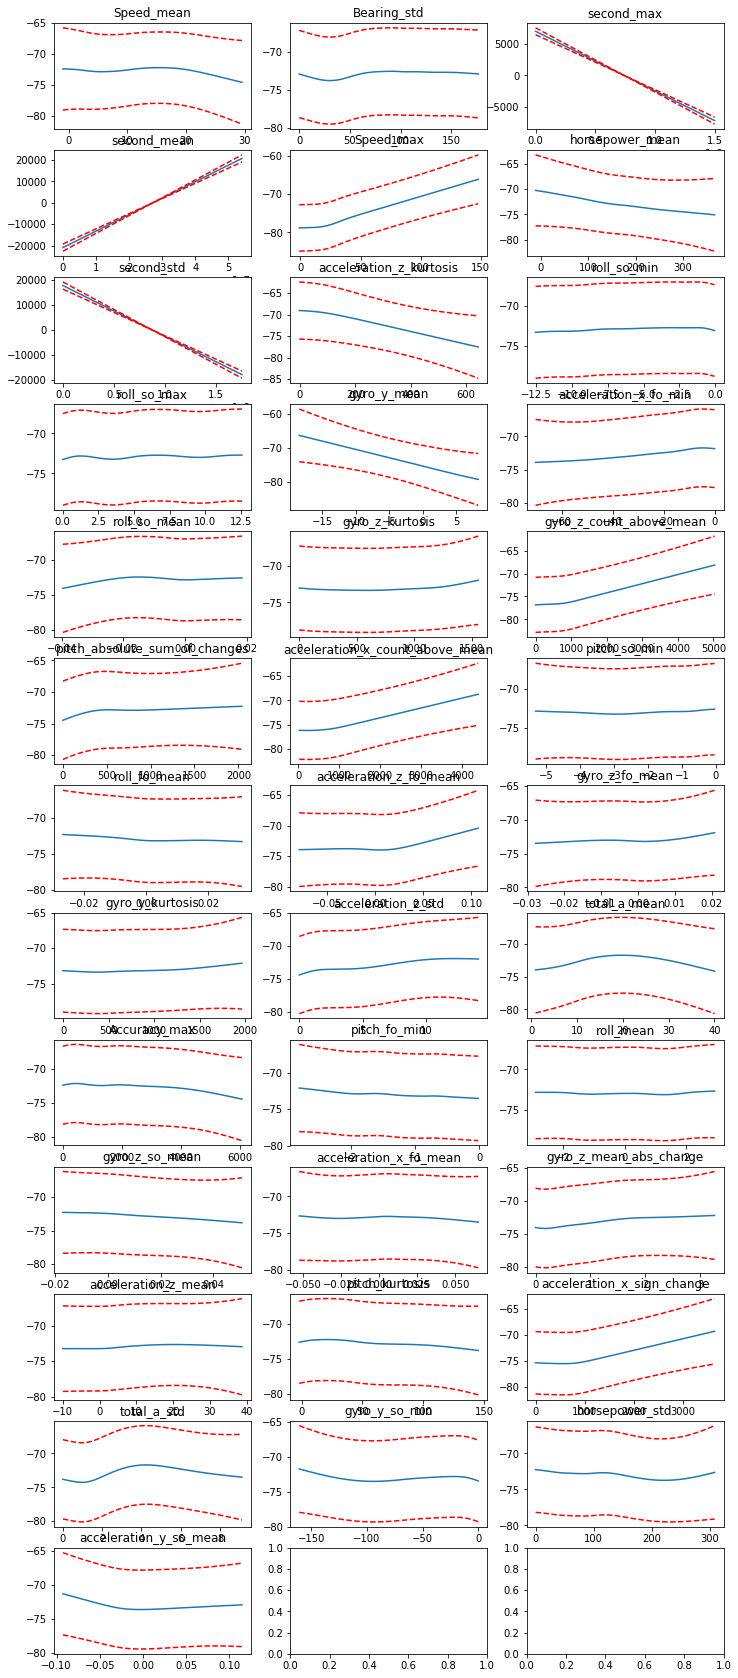

In [126]:
# gam = LogisticGAM().gridsearch(X, y, keep_best=True)

fig, axs = plt.subplots(nrows=13, ncols=3,
                        figsize=(12,30))
titles = features

axs = axs.flatten()

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [0]:
# gam.accuracy(X, y)

# gam.get_params()

In [123]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    125.4997
Link Function:                        LogitLink Log Likelihood:                                 -9709.7566
Number of Samples:                        20000 AIC:                                            19670.5127
                                                AICc:                                           19672.1359
                                                UBRE:                                               2.9885
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1367
Feature Function                  Lam

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [138]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM().fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s roc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

fold 1's roc: 0.7024858474858474


ValueError: ignored

In [0]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))